In [1]:
import urllib3
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

In [2]:
%matplotlib inline

## Gaode Maps API

In [3]:
key = '9294c757894f0133837a27c338bcca77'
api = 'https://restapi.amap.com/v3/config/district'

In [4]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [5]:
def json_response(url):
    http = urllib3.PoolManager()
    response = http.request('GET', url)
    return json.loads(response.data)

In [6]:
def convert_polyline_string(polyline_string):
    polyline = polyline_string.split('|')
    
    # pick the longest string
    polyline = max(polyline, key=len)
    # convert string to list of coordinates
    polyline = [list(map(float, coord.split(','))) for coord in polyline.split(';')]
    
    return polyline

## Country shape

In [7]:
def get_china_polyline_and_districts():
    url = f'{api}?key={key}&keywords=100000&subdistrict=3&extensions=all'
    res = json_response(url)
    china_polyline = convert_polyline_string(res['districts'][0]['polyline'])
    
    provinces = []; cities = []; districts = []
    for i in res['districts'][0]['districts']:
        provinces.append((i['name'], i['adcode']))
        for j in i['districts']:
            cities.append((j['name'], j['adcode']))
            districts += [(k['name'],k['adcode']) for k in j['districts']]
        
    return china_polyline, provinces, cities, districts

In [8]:
# convert polyline to OpenCV contour format
def polyline_to_contour(polyline):
    ctr = np.array(polyline).reshape((-1,1,2))
    ctr -= np.tile(np.amin(ctr, axis=0), (ctr.shape[0],1,1))
    ctr *= 500 / np.amax(ctr)
    return ctr.astype(np.int32)

In [9]:
china_polyline, provinces, cities, districts = get_china_polyline_and_districts()
china_contour = polyline_to_contour(china_polyline)

In [10]:
print(len(provinces))
print(len(cities))
print(len(districts))

34
395
3300


In [11]:
def draw_contour(contour):
    drawing = np.ones([500,500], np.uint8) * 255
    cv2.drawContours(drawing, [contour], 0, (0,0,0), 2)
    
    # trim zeros
    drawing = drawing[~np.all(drawing == 255, axis=0)]
    drawing = drawing[~np.all(drawing == 255, axis=1)]

    plt.axis('off')
    plt.imshow(drawing, cmap='Greys_r', origin='lower')

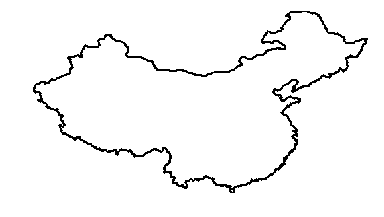

In [12]:
draw_contour(china_contour)

## Provincial (1st) level

In [13]:
def save_obj(obj, name):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(f'{name}.pkl', 'rb') as f:
        return pickle.load(f)

In [14]:
def get_polyline(adcode):
    url = f'{api}?key={key}&keywords={adcode}&subdistrict=0&extensions=all'
    res = json_response(url)
    polyline = convert_polyline_string(res['districts'][0]['polyline'])
    
    return polyline

In [15]:
def read_data(regions, region_data):
    for idx, region in enumerate(regions):
        if not region[1] in region_data:
            region_data[region[1]] = { 'name': region[0] }
        if not 'polyline' in region_data[region[1]]:
            region_data[region[1]]['polyline'] = get_polyline(region[1])
        print(f'{region[0]} ({idx+1}/{len(regions)})')

In [16]:
#province_data = {}
#save_obj(province_data, 'province_data')

In [17]:
province_data = load_obj('province_data')
read_data(provinces, province_data)
save_obj(province_data, 'province_data')

广东省 (1/34)
河南省 (2/34)
内蒙古自治区 (3/34)
黑龙江省 (4/34)
新疆维吾尔自治区 (5/34)
湖北省 (6/34)
辽宁省 (7/34)
山东省 (8/34)
陕西省 (9/34)
上海市 (10/34)
贵州省 (11/34)
重庆市 (12/34)
西藏自治区 (13/34)
安徽省 (14/34)
福建省 (15/34)
湖南省 (16/34)
海南省 (17/34)
江苏省 (18/34)
青海省 (19/34)
广西壮族自治区 (20/34)
宁夏回族自治区 (21/34)
江西省 (22/34)
浙江省 (23/34)
河北省 (24/34)
香港特别行政区 (25/34)
山西省 (26/34)
台湾省 (27/34)
澳门特别行政区 (28/34)
甘肃省 (29/34)
四川省 (30/34)
云南省 (31/34)
北京市 (32/34)
天津市 (33/34)
吉林省 (34/34)


In [18]:
def calc_matches(regions, region_data, method=1):
    for idx, region in enumerate(regions):
        polyline = region_data[region[1]]['polyline']
        contour = polyline_to_contour(polyline)
        match = cv2.matchShapes(china_contour, contour, method, 0.0)
        region_data[region[1]]['match'] = match
        print(f'{region[0]} ({idx+1}/{len(regions)}): {match}')

In [19]:
province_data = load_obj('province_data')
calc_matches(provinces, province_data)
save_obj(province_data, 'province_data')

广东省 (1/34): 0.6994210301837152
河南省 (2/34): 0.722057650221966
内蒙古自治区 (3/34): 3.805435892040462
黑龙江省 (4/34): 0.5376053517105723
新疆维吾尔自治区 (5/34): 0.6384340307736008
湖北省 (6/34): 0.2711972759742246
辽宁省 (7/34): 0.8970485033420174
山东省 (8/34): 0.7858474778333167
陕西省 (9/34): 0.6185600947418853
上海市 (10/34): 0.85379631091199
贵州省 (11/34): 0.8386474916700087
重庆市 (12/34): 0.207466063412164
西藏自治区 (13/34): 0.7677329797686177
安徽省 (14/34): 0.7723058454485191
福建省 (15/34): 0.8032923231538587
湖南省 (16/34): 0.9506077372939299
海南省 (17/34): 0.8130551227504095
江苏省 (18/34): 0.8466625292885478
青海省 (19/34): 0.689540730925427
广西壮族自治区 (20/34): 0.7684758998520174
宁夏回族自治区 (21/34): 0.4720899226739642
江西省 (22/34): 0.6383544536640682
浙江省 (23/34): 0.8137400088946432
河北省 (24/34): 0.3195901424685993
香港特别行政区 (25/34): 0.8738418083727666
山西省 (26/34): 0.7373357187410454
台湾省 (27/34): 0.3417959207628385
澳门特别行政区 (28/34): 0.5242805672057492
甘肃省 (29/34): 3.534566519586941
四川省 (30/34): 0.6867464478482708
云南省 (31/34): 0.82694175965667

In [20]:
def closest_matches(data, n=1):
    sorted_adcodes = sorted(data.keys(), key=lambda x: data[x]['match'])
    first_n_adcodes = sorted_adcodes[:n]
    for adcode in first_n_adcodes:
        print(f'{data[adcode]["name"]} ({adcode}): {data[adcode]["match"]}')
        polyline = data[adcode]["polyline"]
        contour = polyline_to_contour(polyline)
        draw_contour(contour)
        plt.show()

吉林省 (220000): 0.17912271413919773


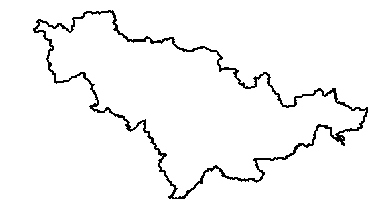

重庆市 (500000): 0.207466063412164


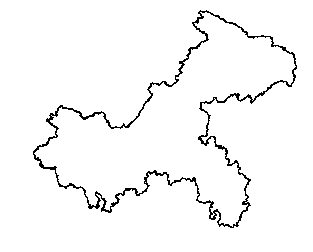

湖北省 (420000): 0.2711972759742246


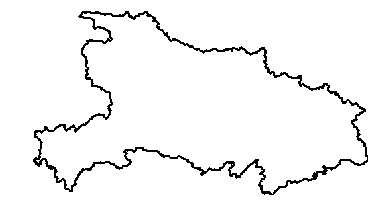

In [21]:
closest_matches(province_data, 3)

## Prefectural (2nd) level

In [22]:
#city_data = {}
#save_obj(city_data, 'city_data')

In [23]:
city_data = load_obj('city_data')
read_data(cities, city_data)
save_obj(city_data, 'city_data')

汕头市 (1/395)
佛山市 (2/395)
珠海市 (3/395)
江门市 (4/395)
湛江市 (5/395)
惠州市 (6/395)
肇庆市 (7/395)
汕尾市 (8/395)
茂名市 (9/395)
深圳市 (10/395)
阳江市 (11/395)
潮州市 (12/395)
韶关市 (13/395)
梅州市 (14/395)
河源市 (15/395)
清远市 (16/395)
东莞市 (17/395)
云浮市 (18/395)
揭阳市 (19/395)
广州市 (20/395)
中山市 (21/395)
东沙群岛 (22/395)
濮阳市 (23/395)
洛阳市 (24/395)
三门峡市 (25/395)
郑州市 (26/395)
许昌市 (27/395)
南阳市 (28/395)
漯河市 (29/395)
济源市 (30/395)
平顶山市 (31/395)
信阳市 (32/395)
焦作市 (33/395)
安阳市 (34/395)
驻马店市 (35/395)
商丘市 (36/395)
新乡市 (37/395)
鹤壁市 (38/395)
周口市 (39/395)
开封市 (40/395)
乌海市 (41/395)
巴彦淖尔市 (42/395)
呼伦贝尔市 (43/395)
鄂尔多斯市 (44/395)
包头市 (45/395)
呼和浩特市 (46/395)
通辽市 (47/395)
赤峰市 (48/395)
阿拉善盟 (49/395)
兴安盟 (50/395)
锡林郭勒盟 (51/395)
乌兰察布市 (52/395)
大兴安岭地区 (53/395)
七台河市 (54/395)
大庆市 (55/395)
鹤岗市 (56/395)
伊春市 (57/395)
绥化市 (58/395)
佳木斯市 (59/395)
齐齐哈尔市 (60/395)
鸡西市 (61/395)
双鸭山市 (62/395)
哈尔滨市 (63/395)
黑河市 (64/395)
牡丹江市 (65/395)
北屯市 (66/395)
双河市 (67/395)
铁门关市 (68/395)
博尔塔拉蒙古自治州 (69/395)
和田地区 (70/395)
塔城地区 (71/395)
昆玉市 (72/395)
可克达拉市 (73/395)
石河子市 (74/395)
阿勒泰地区 (7

In [24]:
city_data = load_obj('city_data')
calc_matches(cities, city_data)
save_obj(city_data, 'city_data')

汕头市 (1/395): 0.76280253325953
佛山市 (2/395): 0.47926558833602484
珠海市 (3/395): 0.9522641799230251
江门市 (4/395): 0.8622800525031677
湛江市 (5/395): 0.41919968289535575
惠州市 (6/395): 0.5255662143307777
肇庆市 (7/395): 0.8611112038882431
汕尾市 (8/395): 0.4189152070330758
茂名市 (9/395): 0.8534909347563786
深圳市 (10/395): 1.3016990303415044
阳江市 (11/395): 1.001125469678796
潮州市 (12/395): 0.7839594318468919
韶关市 (13/395): 0.6548425064102238
梅州市 (14/395): 0.8279120880905186
河源市 (15/395): 0.8397758999282138
清远市 (16/395): 0.49073390243975007
东莞市 (17/395): 0.5242370752364368
云浮市 (18/395): 0.6063989313017365
揭阳市 (19/395): 0.832096836606999
广州市 (20/395): 0.3922534870042702
中山市 (21/395): 0.8693986304660917
东沙群岛 (22/395): 1.3464763926921208
濮阳市 (23/395): 0.8914900791081768
洛阳市 (24/395): 0.8215918184740626
三门峡市 (25/395): 0.8429903338401921
郑州市 (26/395): 0.23260594451096117
许昌市 (27/395): 0.7469983775839539
南阳市 (28/395): 0.6092350449124295
漯河市 (29/395): 0.48383987635305975
济源市 (30/395): 0.4429305100246992
平顶山市 (31/395): 0

南昌市 (271/395): 0.8081489695434605
吉安市 (272/395): 0.7930972294811873
萍乡市 (273/395): 0.6427966632296109
宜春市 (274/395): 0.29955492765810743
宁波市 (275/395): 0.6929042194541675
台州市 (276/395): 0.737189595061832
嘉兴市 (277/395): 0.9081670178130319
舟山市 (278/395): 0.31050744899147864
温州市 (279/395): 0.4045584847486967
衢州市 (280/395): 0.6540561979405181
金华市 (281/395): 0.6976752157448591
丽水市 (282/395): 0.6733553634235189
杭州市 (283/395): 0.7943310332126453
绍兴市 (284/395): 0.8582787549389523
湖州市 (285/395): 0.5940735022284018
邢台市 (286/395): 0.2620180675733671
邯郸市 (287/395): 0.740696470675464
唐山市 (288/395): 0.9640801095734135
承德市 (289/395): 0.8096811658603682
张家口市 (290/395): 0.9235772289037123
廊坊市 (291/395): 1.0304302455820866
沧州市 (292/395): 0.3702524280946671
衡水市 (293/395): 0.9559275910305902
秦皇岛市 (294/395): 0.9652415373873484
保定市 (295/395): 1.160154027562402
石家庄市 (296/395): 0.6280812756092911
深水埗区 (297/395): 0.4162421649600852
西贡区 (298/395): 0.7278289380125721
元朗区 (299/395): 0.7236377888965475
油尖旺区 (300/3

来宾市 (451300): 0.026093123055355688


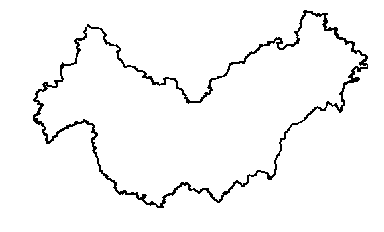

嘉模堂区 (820006): 0.1278166023221231


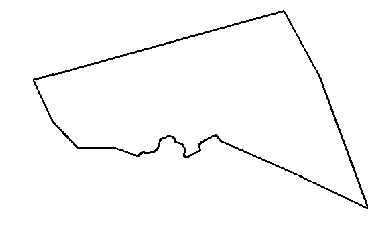

铁门关市 (659006): 0.14899259107180007


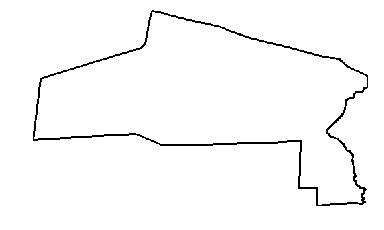

昭通市 (530600): 0.15491503277116872


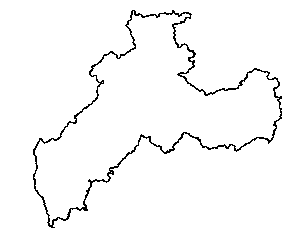

In [25]:
closest_matches(city_data, 4)

## County (3rd) level

In [26]:
#district_data = {}
#save_obj(district_data, 'district_data')

In [27]:
district_data = load_obj('district_data')
read_data(districts, district_data)
save_obj(district_data, 'district_data')

南澳县 (1/3300)
澄海区 (2/3300)
濠江区 (3/3300)
潮阳区 (4/3300)
潮南区 (5/3300)
龙湖区 (6/3300)
金平区 (7/3300)
三水区 (8/3300)
高明区 (9/3300)
顺德区 (10/3300)
禅城区 (11/3300)
南海区 (12/3300)
香洲区 (13/3300)
斗门区 (14/3300)
金湾区 (15/3300)
澳门大学横琴校区(由澳门管辖) (16/3300)
鹤山市 (17/3300)
江海区 (18/3300)
开平市 (19/3300)
台山市 (20/3300)
恩平市 (21/3300)
新会区 (22/3300)
蓬江区 (23/3300)
吴川市 (24/3300)
廉江市 (25/3300)
雷州市 (26/3300)
徐闻县 (27/3300)
霞山区 (28/3300)
麻章区 (29/3300)
坡头区 (30/3300)
赤坎区 (31/3300)
遂溪县 (32/3300)
龙门县 (33/3300)
博罗县 (34/3300)
惠东县 (35/3300)
惠阳区 (36/3300)
惠城区 (37/3300)
怀集县 (38/3300)
封开县 (39/3300)
广宁县 (40/3300)
四会市 (41/3300)
德庆县 (42/3300)
鼎湖区 (43/3300)
端州区 (44/3300)
高要区 (45/3300)
陆河县 (46/3300)
陆丰市 (47/3300)
海丰县 (48/3300)
城区 (49/3300)
信宜市 (50/3300)
化州市 (51/3300)
高州市 (52/3300)
电白区 (53/3300)
茂南区 (54/3300)
宝安区 (55/3300)
南山区 (56/3300)
福田区 (57/3300)
盐田区 (58/3300)
罗湖区 (59/3300)
龙华区 (60/3300)
龙岗区 (61/3300)
坪山区 (62/3300)
阳春市 (63/3300)
江城区 (64/3300)
阳西县 (65/3300)
阳东区 (66/3300)
饶平县 (67/3300)
湘桥区 (68/3300)
潮安区 (69/3300)
仁化县 (70/3300)
南雄市 (71/3300)
曲江区 

安多县 (1446/3300)
班戈县 (1447/3300)
比如县 (1448/3300)
申扎县 (1449/3300)
索县 (1450/3300)
色尼区 (1451/3300)
嘉黎县 (1452/3300)
尼玛县 (1453/3300)
双湖县 (1454/3300)
仲巴县 (1455/3300)
昂仁县 (1456/3300)
谢通门县 (1457/3300)
南木林县 (1458/3300)
萨嘎县 (1459/3300)
桑珠孜区 (1460/3300)
拉孜县 (1461/3300)
吉隆县 (1462/3300)
仁布县 (1463/3300)
萨迦县 (1464/3300)
白朗县 (1465/3300)
定日县 (1466/3300)
江孜县 (1467/3300)
聂拉木县 (1468/3300)
康马县 (1469/3300)
岗巴县 (1470/3300)
定结县 (1471/3300)
亚东县 (1472/3300)
桑日县 (1473/3300)
加查县 (1474/3300)
乃东区 (1475/3300)
贡嘎县 (1476/3300)
扎囊县 (1477/3300)
浪卡子县 (1478/3300)
隆子县 (1479/3300)
琼结县 (1480/3300)
曲松县 (1481/3300)
措美县 (1482/3300)
洛扎县 (1483/3300)
错那县 (1484/3300)
波密县 (1485/3300)
工布江达县 (1486/3300)
巴宜区 (1487/3300)
墨脱县 (1488/3300)
米林县 (1489/3300)
察隅县 (1490/3300)
朗县 (1491/3300)
札达县 (1492/3300)
改则县 (1493/3300)
措勤县 (1494/3300)
普兰县 (1495/3300)
噶尔县 (1496/3300)
日土县 (1497/3300)
革吉县 (1498/3300)
太和县 (1499/3300)
临泉县 (1500/3300)
颍泉区 (1501/3300)
颍东区 (1502/3300)
颍州区 (1503/3300)
阜南县 (1504/3300)
颍上县 (1505/3300)
界首市 (1506/3300)
杜集区 (1507/3300)
相山区

桐乡市 (2446/3300)
海宁市 (2447/3300)
秀洲区 (2448/3300)
南湖区 (2449/3300)
嘉善县 (2450/3300)
海盐县 (2451/3300)
定海区 (2452/3300)
普陀区 (2453/3300)
岱山县 (2454/3300)
嵊泗县 (2455/3300)
平阳县 (2456/3300)
洞头区 (2457/3300)
瑞安市 (2458/3300)
苍南县 (2459/3300)
鹿城区 (2460/3300)
永嘉县 (2461/3300)
泰顺县 (2462/3300)
文成县 (2463/3300)
乐清市 (2464/3300)
龙湾区 (2465/3300)
瓯海区 (2466/3300)
衢江区 (2467/3300)
柯城区 (2468/3300)
常山县 (2469/3300)
开化县 (2470/3300)
龙游县 (2471/3300)
江山市 (2472/3300)
浦江县 (2473/3300)
永康市 (2474/3300)
武义县 (2475/3300)
兰溪市 (2476/3300)
东阳市 (2477/3300)
婺城区 (2478/3300)
磐安县 (2479/3300)
金东区 (2480/3300)
义乌市 (2481/3300)
莲都区 (2482/3300)
松阳县 (2483/3300)
龙泉市 (2484/3300)
遂昌县 (2485/3300)
云和县 (2486/3300)
缙云县 (2487/3300)
景宁畲族自治县 (2488/3300)
青田县 (2489/3300)
庆元县 (2490/3300)
富阳区 (2491/3300)
桐庐县 (2492/3300)
西湖区 (2493/3300)
上城区 (2494/3300)
建德市 (2495/3300)
淳安县 (2496/3300)
余杭区 (2497/3300)
萧山区 (2498/3300)
滨江区 (2499/3300)
江干区 (2500/3300)
下城区 (2501/3300)
临安区 (2502/3300)
拱墅区 (2503/3300)
上虞区 (2504/3300)
嵊州市 (2505/3300)
新昌县 (2506/3300)
越城区 (2507/3300)
柯桥区 

In [28]:
district_data = load_obj('district_data')
calc_matches(districts, district_data)
save_obj(district_data, 'district_data')

南澳县 (1/3300): 1.196725385098281
澄海区 (2/3300): 0.8705733318188926
濠江区 (3/3300): 0.8089590826823789
潮阳区 (4/3300): 0.7381176371216188
潮南区 (5/3300): 1.0796035856653523
龙湖区 (6/3300): 0.8654052506133864
金平区 (7/3300): 0.7541814564629139
三水区 (8/3300): 0.868886967986955
高明区 (9/3300): 0.5968374556705067
顺德区 (10/3300): 1.0712799400142703
禅城区 (11/3300): 0.5679747144161676
南海区 (12/3300): 0.7533546810466444
香洲区 (13/3300): 0.7340942230819782
斗门区 (14/3300): 0.7952092472321761
金湾区 (15/3300): 0.6689351273860902
澳门大学横琴校区(由澳门管辖) (16/3300): 0.47135487919413877
鹤山市 (17/3300): 0.573723868429414
江海区 (18/3300): 0.8818984911128187
开平市 (19/3300): 0.8448695775574571
台山市 (20/3300): 0.9116100735582766
恩平市 (21/3300): 0.7994989857288067
新会区 (22/3300): 0.7561212622002159
蓬江区 (23/3300): 0.7522350041331074
吴川市 (24/3300): 0.6072507689753641
廉江市 (25/3300): 0.7378744803635118
雷州市 (26/3300): 1.0111824486809011
徐闻县 (27/3300): 0.8736269999919498
霞山区 (28/3300): 0.9459028979230559
麻章区 (29/3300): 0.6188993571416466
坡头区 (30/3300)

上蔡县 (300/3300): 0.5875896245284467
西平县 (301/3300): 0.6732830734067998
汝南县 (302/3300): 0.673326644807632
平舆县 (303/3300): 0.9142282667968777
新蔡县 (304/3300): 0.6405494544977377
泌阳县 (305/3300): 0.94363682807674
遂平县 (306/3300): 0.8363356337380918
驿城区 (307/3300): 0.4720470670220167
确山县 (308/3300): 0.8879177074533798
正阳县 (309/3300): 0.7810018114410937
民权县 (310/3300): 0.3654520850851266
宁陵县 (311/3300): 0.7554902803183786
睢县 (312/3300): 1.0460634165418639
睢阳区 (313/3300): 0.6814884541760359
永城市 (314/3300): 0.638848372358793
夏邑县 (315/3300): 0.7422391818471018
柘城县 (316/3300): 0.6458818441310801
梁园区 (317/3300): 0.8645442171616748
虞城县 (318/3300): 0.23500337109962827
红旗区 (319/3300): 0.47464617803555037
凤泉区 (320/3300): 1.7632912032876085
辉县市 (321/3300): 0.8299035831667447
获嘉县 (322/3300): 0.8419682541500277
卫辉市 (323/3300): 0.37226510377837285
延津县 (324/3300): 0.5930758512778384
封丘县 (325/3300): 0.5746658854203569
原阳县 (326/3300): 0.29766464292392214
长垣县 (327/3300): 0.6363220949752061
新乡县 (328/3300): 0.559

松北区 (566/3300): 0.4502866018629633
五常市 (567/3300): 0.9982035499173465
南岗区 (568/3300): 1.8536308350756254
道外区 (569/3300): 0.46521023217674495
阿城区 (570/3300): 0.4457087682612001
逊克县 (571/3300): 1.0927996185636935
孙吴县 (572/3300): 0.5885202925370219
嫩江县 (573/3300): 0.7996930827980206
爱辉区 (574/3300): 0.9427159760523991
五大连池市 (575/3300): 0.6573861557384423
北安市 (576/3300): 0.6939295110821753
东安区 (577/3300): 1.7938833366756248
爱民区 (578/3300): 0.5701718134447445
绥芬河市 (579/3300): 0.9647688692565735
东宁市 (580/3300): 0.8867398140192931
宁安市 (581/3300): 0.9721605869639729
穆棱市 (582/3300): 0.228073336348766
阳明区 (583/3300): 0.791719346446751
林口县 (584/3300): 0.4738073761081249
西安区 (585/3300): 0.6384798550234234
海林市 (586/3300): 0.6721726013630391
北屯镇 (587/3300): 1.6096043157712316
兵团一八八团 (588/3300): 1.6096043157712316
兵团一八三团 (589/3300): 1.6096043157712316
兵团一八七团 (590/3300): 1.6096043157712316
兵团八十九团 (591/3300): 2.351421850928201
兵团八十六团 (592/3300): 2.351421850928201
兵团八十四团 (593/3300): 2.351421850928201
兵团九

麻洋镇 (821/3300): 0.6465174213606498
杨林街道 (822/3300): 0.6465174213606498
白茅湖农场 (823/3300): 0.6465174213606498
汪场镇 (824/3300): 0.6465174213606498
渔薪镇 (825/3300): 0.6465174213606498
净潭乡 (826/3300): 0.6465174213606498
卢市镇 (827/3300): 0.6465174213606498
皂市镇 (828/3300): 0.6465174213606498
拖市镇 (829/3300): 0.6465174213606498
张港镇 (830/3300): 0.6465174213606498
红安县 (831/3300): 0.6821156613256661
英山县 (832/3300): 0.6377018254989762
罗田县 (833/3300): 0.6020003970657841
团风县 (834/3300): 0.4768466581511478
浠水县 (835/3300): 0.8075381447463
麻城市 (836/3300): 0.9706399209515613
蕲春县 (837/3300): 0.41526868971765507
黄州区 (838/3300): 1.0570582415387086
黄梅县 (839/3300): 0.7424453572588929
武穴市 (840/3300): 0.956778875747038
积玉口镇 (841/3300): 1.0404158212265684
广华街道 (842/3300): 1.0404158212265684
泰丰街道 (843/3300): 1.0404158212265684
潜江经济开发区 (844/3300): 1.0404158212265684
周矶管理区 (845/3300): 1.0404158212265684
周矶街道 (846/3300): 1.0404158212265684
总口管理区 (847/3300): 1.0404158212265684
高场街道 (848/3300): 1.0404158212265684
王场镇 (84

淄川区 (1081/3300): 0.7005230830474631
沂源县 (1082/3300): 0.7176164066848618
博山区 (1083/3300): 0.36240626647496765
莱西市 (1084/3300): 0.6858327464182494
平度市 (1085/3300): 0.8908448928782522
即墨区 (1086/3300): 0.7604073211164767
崂山区 (1087/3300): 0.9218791430608878
城阳区 (1088/3300): 0.9594842578737065
李沧区 (1089/3300): 0.4300780421031845
黄岛区 (1090/3300): 0.39192291342670715
市南区 (1091/3300): 2.6747819956816263
胶州市 (1092/3300): 0.7030285078691962
市北区 (1093/3300): 0.785453626816299
临清市 (1094/3300): 0.8478978385618621
茌平县 (1095/3300): 1.0859186947598107
冠县 (1096/3300): 0.7525814416587253
东昌府区 (1097/3300): 0.823801012908683
东阿县 (1098/3300): 0.41095254610836
高唐县 (1099/3300): 0.8456187635792944
莘县 (1100/3300): 0.6031349549343146
阳谷县 (1101/3300): 0.8028298827026714
宁津县 (1102/3300): 0.8523948731685377
陵城区 (1103/3300): 0.7214020185151031
乐陵市 (1104/3300): 0.8962435943275835
庆云县 (1105/3300): 0.9783550354059195
德城区 (1106/3300): 0.9180438763749234
临邑县 (1107/3300): 0.7690599052399092
武城县 (1108/3300): 0.856960647879

镇宁布依族苗族自治县 (1366/3300): 0.9147832966383439
关岭布依族苗族自治县 (1367/3300): 0.4876601925614141
平坝区 (1368/3300): 0.8258603424111798
七星关区 (1369/3300): 0.7094491962602933
大方县 (1370/3300): 0.7084345545882955
黔西县 (1371/3300): 0.8454045032421049
金沙县 (1372/3300): 0.4635343372003026
纳雍县 (1373/3300): 0.7997814238014638
织金县 (1374/3300): 0.5739591787597399
赫章县 (1375/3300): 0.6913110647845235
威宁彝族回族苗族自治县 (1376/3300): 1.0627724515120827
开阳县 (1377/3300): 0.8392037215848414
白云区 (1378/3300): 0.4735429574509828
乌当区 (1379/3300): 0.7608623856766655
观山湖区 (1380/3300): 0.8115396785276282
息烽县 (1381/3300): 0.8476111531183573
修文县 (1382/3300): 0.2482442952931188
清镇市 (1383/3300): 0.8659956514852473
花溪区 (1384/3300): 1.0367001683321604
南明区 (1385/3300): 0.6452697421298992
云岩区 (1386/3300): 0.8690226123527671
城口县 (1387/3300): 0.8222130993311145
巫溪县 (1388/3300): 0.747222007655282
奉节县 (1389/3300): 0.7820627452278797
丰都县 (1390/3300): 0.7379961433947544
彭水苗族土家族自治县 (1391/3300): 0.7750620156733459
垫江县 (1392/3300): 0.776972504336352

安溪县 (1642/3300): 0.8970996198934996
泉港区 (1643/3300): 1.0511403968731998
丰泽区 (1644/3300): 0.9483870111029379
惠安县 (1645/3300): 0.7958920538691643
晋江市 (1646/3300): 0.6610389822553853
石狮市 (1647/3300): 0.8316235920271888
金门县 (1648/3300): 0.6875917733772354
鲤城区 (1649/3300): 0.8618707151526273
宁化县 (1650/3300): 0.5939341741693726
泰宁县 (1651/3300): 0.46284069671474787
大田县 (1652/3300): 0.7830938260934991
梅列区 (1653/3300): 0.8049436544669302
永安市 (1654/3300): 0.6884233248932956
三元区 (1655/3300): 0.34359919614735634
清流县 (1656/3300): 0.7333269939400382
沙县 (1657/3300): 0.8310746994169411
建宁县 (1658/3300): 1.0738652490923424
尤溪县 (1659/3300): 0.8433650308895887
将乐县 (1660/3300): 0.9013496961728191
明溪县 (1661/3300): 0.4966803703008359
同安区 (1662/3300): 0.8869755643589674
海沧区 (1663/3300): 0.6946005668007178
集美区 (1664/3300): 0.6041411477889711
湖里区 (1665/3300): 0.5713450582811952
思明区 (1666/3300): 0.9250243808390646
翔安区 (1667/3300): 0.8606809358651529
华安县 (1668/3300): 0.3958649410121561
南靖县 (1669/3300): 0.83466583

蓬莱镇 (1928/3300): 0.4510352386597729
抱罗镇 (1929/3300): 0.4510352386597729
潭牛镇 (1930/3300): 0.4510352386597729
东路镇 (1931/3300): 0.4510352386597729
文城镇 (1932/3300): 0.4510352386597729
重兴镇 (1933/3300): 0.4510352386597729
南圣镇 (1934/3300): 0.953482217739192
毛阳镇 (1935/3300): 0.953482217739192
国营畅好农场 (1936/3300): 0.953482217739192
番阳镇 (1937/3300): 0.953482217739192
水满乡 (1938/3300): 0.953482217739192
通什镇 (1939/3300): 0.953482217739192
畅好乡 (1940/3300): 0.953482217739192
毛道乡 (1941/3300): 0.953482217739192
海南保亭热带作物研究所 (1942/3300): 0.8726821937286896
新政镇 (1943/3300): 0.8726821937286896
加茂镇 (1944/3300): 0.8726821937286896
国营新星农场 (1945/3300): 0.8726821937286896
保城镇 (1946/3300): 0.8726821937286896
国营金江农场 (1947/3300): 0.8726821937286896
南林乡 (1948/3300): 0.8726821937286896
国营三道农场 (1949/3300): 0.8726821937286896
毛感乡 (1950/3300): 0.8726821937286896
响水镇 (1951/3300): 0.8726821937286896
什玲镇 (1952/3300): 0.8726821937286896
三道镇 (1953/3300): 0.8726821937286896
六弓乡 (1954/3300): 0.8726821937286896
永发镇 (1955/3300):

田阳区 (2222/3300): 0.12878623050067875
靖西市 (2223/3300): 0.6349788256453927
田林县 (2224/3300): 0.7448975167690024
那坡县 (2225/3300): 0.7959973728021061
合浦县 (2226/3300): 0.4762392586206423
海城区 (2227/3300): 0.2657938254074734
银海区 (2228/3300): 0.6360238760111957
铁山港区 (2229/3300): 0.8490170298545667
平南县 (2230/3300): 0.2865385583598219
桂平市 (2231/3300): 0.7591689730054747
覃塘区 (2232/3300): 0.6287434272994725
港南区 (2233/3300): 0.7161475998556943
港北区 (2234/3300): 0.9020502206782579
环江毛南族自治县 (2235/3300): 0.8641379445417736
金城江区 (2236/3300): 0.6983770611829069
罗城仫佬族自治县 (2237/3300): 0.9077906700662965
天峨县 (2238/3300): 0.8685637059674366
宜州区 (2239/3300): 0.7974063759181211
凤山县 (2240/3300): 0.7603213222801193
南丹县 (2241/3300): 0.6972047304585471
大化瑶族自治县 (2242/3300): 0.8433666209437674
巴马瑶族自治县 (2243/3300): 0.9748220385375204
都安瑶族自治县 (2244/3300): 0.9135194646329141
东兰县 (2245/3300): 0.7750217092779373
融安县 (2246/3300): 0.8014985068676472
融水苗族自治县 (2247/3300): 0.8084507063595918
三江侗族自治县 (2248/3300): 0.997980099685

曲周县 (2544/3300): 0.5027137924209228
鸡泽县 (2545/3300): 0.910179340230105
磁县 (2546/3300): 0.6797210558072777
丛台区 (2547/3300): 1.3837617075933488
复兴区 (2548/3300): 0.4077884757993679
永年区 (2549/3300): 0.5925849885406193
邯山区 (2550/3300): 0.43897453984151186
成安县 (2551/3300): 0.7173048550887904
滦南县 (2552/3300): 0.812037672777577
乐亭县 (2553/3300): 0.6614539938351978
迁西县 (2554/3300): 0.8982782842930379
遵化市 (2555/3300): 0.7005791682182678
迁安市 (2556/3300): 0.8278477855396206
滦县 (2557/3300): 0.6668778595596536
曹妃甸区 (2558/3300): 0.6744366918213499
玉田县 (2559/3300): 1.0046865359960042
路南区 (2560/3300): 0.6543238195289236
丰南区 (2561/3300): 0.7641857668581788
路北区 (2562/3300): 0.4600196644715382
丰润区 (2563/3300): 0.3321483020200027
古冶区 (2564/3300): 0.7187615761250631
开平区 (2565/3300): 0.6846257066017217
围场满族蒙古族自治县 (2566/3300): 0.6497681029131677
宽城满族自治县 (2567/3300): 0.9234006243761842
隆化县 (2568/3300): 0.26175112182081595
鹰手营子矿区 (2569/3300): 0.8861029144207334
丰宁满族自治县 (2570/3300): 0.7283969352357009
平泉市 (2571/3

肃州区 (2824/3300): 0.707037553847413
金塔县 (2825/3300): 0.42047041036559907
阿克塞哈萨克族自治县 (2826/3300): 1.8403246658787586
瓜州县 (2827/3300): 0.5947043450078291
崆峒区 (2828/3300): 0.9202333628910724
灵台县 (2829/3300): 0.7966496660441365
庄浪县 (2830/3300): 0.5327549200810897
崇信县 (2831/3300): 0.831902687422
华亭县 (2832/3300): 0.7019961667167965
静宁县 (2833/3300): 0.7802332864154968
泾川县 (2834/3300): 0.6128544982427584
靖远县 (2835/3300): 0.9202762519979577
白银区 (2836/3300): 0.753337772876919
平川区 (2837/3300): 2.360953253187875
景泰县 (2838/3300): 0.8384638803354736
会宁县 (2839/3300): 0.7783586108528658
高台县 (2840/3300): 1.029515439549512
肃南裕固族自治县 (2841/3300): 3.5502193532256388
临泽县 (2842/3300): 0.9318700432871144
甘州区 (2843/3300): 0.7823448966537666
山丹县 (2844/3300): 0.47731731988641246
民乐县 (2845/3300): 0.9062762264628252
舟曲县 (2846/3300): 0.3261140194322515
夏河县 (2847/3300): 0.9360656922448698
迭部县 (2848/3300): 0.6219010729330324
玛曲县 (2849/3300): 0.6224163588440983
碌曲县 (2850/3300): 0.8216935878192289
合作市 (2851/3300): 0.649

屏边苗族自治县 (3106/3300): 0.9352495718211785
红河县 (3107/3300): 0.7790129812112572
元阳县 (3108/3300): 0.7433584386652929
蒙自市 (3109/3300): 0.7037988523584977
河口瑶族自治县 (3110/3300): 1.951466564128431
绿春县 (3111/3300): 0.845558919586593
金平苗族瑶族傣族自治县 (3112/3300): 0.7407018241900967
玉龙纳西族自治县 (3113/3300): 0.956199542080358
宁蒗彝族自治县 (3114/3300): 0.3841195500344746
华坪县 (3115/3300): 0.9113333400528554
古城区 (3116/3300): 0.2896856554827239
永胜县 (3117/3300): 0.7355707110834421
景洪市 (3118/3300): 0.7878360847560487
勐腊县 (3119/3300): 0.5437443779029271
勐海县 (3120/3300): 0.8871711830167437
隆阳区 (3121/3300): 0.8965676482004173
腾冲市 (3122/3300): 0.540811783293661
昌宁县 (3123/3300): 0.27176787500655797
施甸县 (3124/3300): 0.5677862140326257
龙陵县 (3125/3300): 0.6714963919461019
丘北县 (3126/3300): 0.8030591813317824
广南县 (3127/3300): 0.8998998637527494
文山市 (3128/3300): 0.8127478879217371
砚山县 (3129/3300): 1.388199448678598
西畴县 (3130/3300): 0.4141732988464186
马关县 (3131/3300): 0.5223686436968136
麻栗坡县 (3132/3300): 0.8144686213557873
富宁县 (3

新城区 (610102): 0.039245540963148084


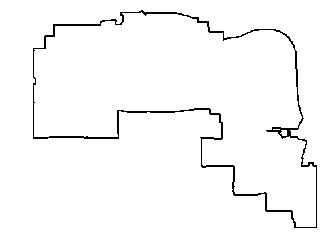

巴楚县 (653130): 0.07573184435156488


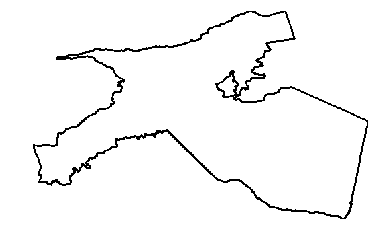

萨迦县 (540224): 0.09554130873847796


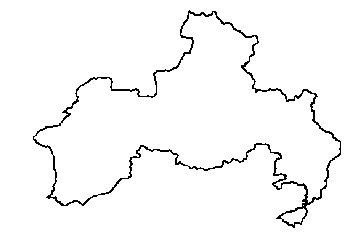

坊子区 (370704): 0.09606003313739836


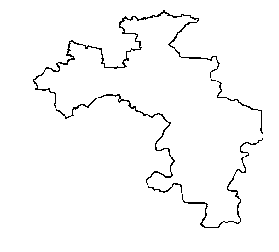

孝义市 (141181): 0.0961154135363185


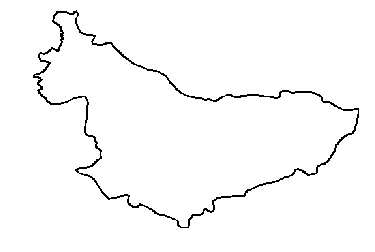

宁乡市 (430182): 0.10089622020512806


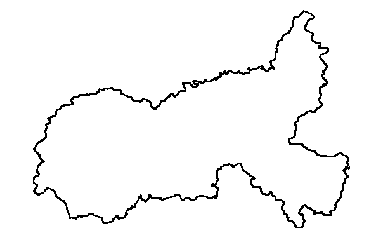

清徐县 (140121): 0.1086057478191601


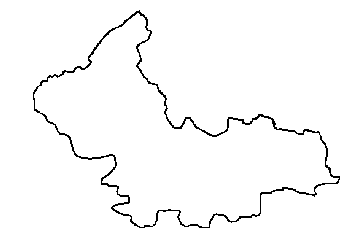

碧江区 (520602): 0.10957003554938577


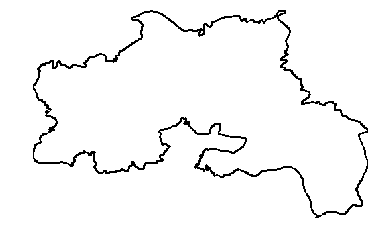

伍家岗区 (420503): 0.11595198821091962


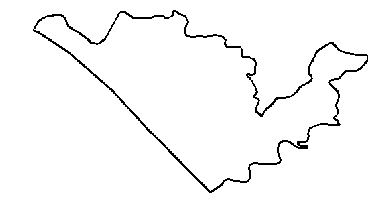

柯坪县 (652929): 0.12075629023658332


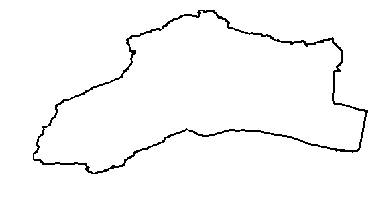

In [29]:
closest_matches(district_data, 10)